In [1]:
# -*- coding: utf-8 -*
import twitter
import csv
import json
import re
import requests
import lxml.html as html
from urllib2 import urlopen
import pandas as pd
from datetime import datetime, timedelta
from dateutil import tz
import time
import sklearn.cross_validation as cv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
class TJLoader:

    def __init__(self):
        self._news_pages = ["https://tjournal.ru/paper/page/{}"]
        self._month_map = {u"января":"01", u"февраля":"02", u"марта":"03", u"апреля":"04", u"мая":"05", u"июня":"06", u"июля":"07", u"августа":"08", u"сентября":"09", u"октября":"10", u"ноября":"11", u"декабря":"12"}

    def get_news_uri(self, min_index=10, count=30):
        """

        :param min_index: int, индекс страницы, с которой нужно начать поиск
        :param count: int, количество страниц, которые нужно скачать
        :return: list. список ссылок на новости
        """
        links = []
        for news_page in self._news_pages:
            
            for i in range(count):
                page = html.parse(urlopen(news_page.format(i+min_index)))
                divs = page.getroot().find_class('b-articles__b__title')

                for div in divs:
                    links.append(div.getchildren()[1].get("href"))
                    
        return links

    
    def _parse_date(self, date):
        date = date.replace(",", "")
        date = date.split(" ")
        
        converted_date = date[2]
        converted_date +="-"+self._month_map[date[1]]
        converted_date +="-"+date[0]
        
        converted_date +=" "+date[3]
        
        return converted_date
        

    def get_link_info(self, link):
        """

        :param link: str, url страницы с tjournal, для которой нужно собрать информацию
        :return: dict с данными со страницы
        """
        page = html.parse(urlopen(link))
        root = page.getroot()

        # заголовок
        title = root.find_class("b-article__title")
        title = title[0].find("h1").text

        # парсим количество просмотров
        view = root.get_element_by_id("hitsCount").text
        view = view.replace(" ", "")
        view = int(view)

        # Количество комментариев
        comments = root.find_class("b-article__infoline__comments")
        comment = int(comments[0].find("b").text.replace(" ", ""))

        
        # Дата
        date = root.find_class("b-article__infoline__date")
        date = self._parse_date(date[0].text)
        
        
        # Type
        news_type = "TJ_P"
            
        return {
            "url": link, 
            "title": title, 
            "views": view, 
            "comments": comment, 
            "news_created_date": date, 
            "collect_date": datetime.today().strftime("%Y-%m-%d %H:%M"),
            "type": news_type
        }
    


    def get_tj_news_info(self, min_index=1, count=1, first_date="2017-01-01", last_date="2010-01-01"):
        """
        :param min_index: int, индекс минимальной страницы, откуда начинаем поиск
        :param count: int, количество страниц, по которым ищем
        :first_date: время первой новости, которую мы скачаем
        :last_date: время последней новости, которую мы скачаем
        :return: dict с данными со страницы
        """
        links = self.get_news_uri(min_index=min_index, count=count)
        link_info_list = []
        i = 0
        is_break = False
        for link in links:
            link_info = self.get_link_info(link)
            # Если заданное время не подходит
            if link_info["news_created_date"] > first_date or link_info["news_created_date"] < last_date:
                continue
    
            link_info_list.append(link_info)
            
            i+=1
            if i%10 == 0:
                print "Скачали ", i, " страниц"

        return link_info_list

In [3]:
class VCLoader:

    def __init__(self):
        self._news_pages = "https://api.vc.ru/1/paper"
        self._month_map = {u"января":"01", u"февраля":"02", u"марта":"03", u"апреля":"04", u"мая":"05", u"июня":"06", u"июля":"07", u"августа":"08", u"сентября":"09", u"октября":"10", u"ноября":"11", u"декабря":"12"}

    def get_news_uri(self, min_index=10, count=30):
        """

        :param min_index: int, индекс страницы, с которой нужно начать поиск
        :param count: int, количество страниц, которые нужно скачать
        :return: list. список ссылок на новости
        """
        links = []
        text = requests.get(self._news_pages).text
        json_req = json.loads(text)
    
        for news in json_req:
            links.append(news["url"])

        return links

    
    def _parse_date(self, date):
        date = date.replace(",", "")
        date = date.split(" ")
        
        converted_date = date[2]
        converted_date +="-"+self._month_map[date[1]]
        converted_date +="-"+date[0]
        
        converted_date +=" "+date[3]
        
        return converted_date
        

    def get_link_info(self, link):
        """

        :param link: str, url страницы с vc, для которой нужно собрать информацию
        :return: dict с данными со страницы
        """
        page = html.parse(urlopen(link))
        root = page.getroot()

        # заголовок
        title = root.find_class("b-article__head")
        title = title[0].find("h1").text

        # парсим количество просмотров
        view = root.get_element_by_id("hitsCount").text
        view = view.replace(" ", "")
        view = int(view)

        # Количество комментариев
        comments = root.find_class("ccount")[0].text
        comment = int(comments.replace(" ", ""))

        # Теги
        tags = root.find_class("b-tags__tag")
        tag_list = []
        for tag in tags:
            tag_list.append(tag.text)
        
        # Дата
        date = root.find_class("b-article__infopanel__date")
        date = self._parse_date(date[0].text)
        

        return {
                "url": link, 
                "title": title, 
                "views": view, 
                "comments": comment, 
                "news_created_date": date, 
                "collect_date": datetime.today().strftime("%Y-%m-%d %H:%M"),
                "type": "VC"
               }


    def get_tj_news_info(self, min_index=1, count=30, first_date="2010-01-01", last_date="2017-01-01"):
        """
        :param min_index: int, индекс минимальной страницы, откуда начинаем поиск
        :param count: int, количество страниц, по которым ищем
        :first_date: str, дата и время первой (самой новой) новости
        :last_date: str, дата и время последней(самой старой) новости
        
        :return: dict с данными со страницы
        """
        links = self.get_news_uri(min_index=min_index, count=count)
        link_info_list = []
        i = 0
        
        for link in links:
            
            link_info = self.get_link_info(link)
            # Если заданное время не подходит
            if link_info["news_created_date"] < first_date or link_info["news_created_date"] > last_date:
                print "continue"
                continue
            
            link_info_list.append(link_info)
            
            i+=1
            if i%10 == 0:
                print "Скачали ", i, " страниц"

        return link_info_list

In [4]:
class TwitterLoader:


    def __init__(self):
        CONSUMER_KEY = 'BOuuaMDhNhm6yx0rzqK8bMsbI'
        CONSUMER_SECRET = '3DybJwlkXd2vU6R385yLA8yJblYJltLtwojySD9AVs04ShauZ0'

        ACCESS_TOKEN_KEY = '3712177576-of3jzZ8gNmlPDfPjPyR0Ljw1Ao2IXdTqX9dZGDZ'
        ACCESS_TOKEN_SECRET = 'Ky7iKwByHNXX3UMfuMhv6UgVx2IhjLo3KmwpsBQz35wtG'

        self.api = twitter.Api(consumer_key=CONSUMER_KEY,
                  consumer_secret=CONSUMER_SECRET,
                  access_token_key=ACCESS_TOKEN_KEY,
                  access_token_secret=ACCESS_TOKEN_SECRET)
        self._month_dict = {"Jan":"1", "Feb":"2", "Mar":"3", "Apr":"4", "May":"5", "Jun":"6", "Jul":"7", "Aug":"8", "Sep":"9", "Oct":"10", "Nov":"11", "Dec":"12"}

        self._UTC_TIME_ZONE = tz.gettz('Europe/London')
        self._MOSCOW_TIME_ZONE = tz.gettz('Europe/Moscow')
        self._RATE_LIMIT = "[{u'message': u'Rate limit exceeded', u'code': 88}]"



    def _parse_date(self, date):

        """

        :param date: str, дата в формате твиттера - "Sat Nov 21 17:00:29 +0000 2015"
        :return: str, дата в человеческом, но буржуйском формате, да еще и в Московском часовом поясе
        """
        date_array = date.split(' ')
        month = self._month_dict[date_array[1]]
        day = int(date_array[2])
        time = date_array[3]
        year = date_array[5]

        date = str(year)+"-"+str(month)+"-"+str(day)+" "+time
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        utc_date = date.replace(tzinfo=self._UTC_TIME_ZONE)
        moscow_date = utc_date.astimezone(self._MOSCOW_TIME_ZONE)

        return str(moscow_date).split("+")[0]



    def loadTweetWithLink(self, link):
        """

        :param link: str, ключевое слово для поиска, вданном случае - ссылка на письмо
        :return: список словариков с информацией о УНИКАЛЬНЫХ твитах по запросу link
        """
        set_id = set()
        tweet_list = []
        result = self.api.GetSearch(term=link, count=100000)

        for res in result:

            tw_id = res.GetId()
            # Если мы уже обрабатывали этот твит - идем дальше
            if tw_id in set_id:
                continue

            retweeted_status = res.GetRetweeted_status()
            # Если это не ретвит
            if retweeted_status is None:
                is_retweet = 0
                retweeted_count = res.GetRetweetCount()
                favorite_count = res.GetFavoriteCount()
            else:
                is_retweet = 1
                retweeted_count = 0
                favorite_count = 0
            set_id.add(tw_id)

            created_at = res.GetCreatedAt()
            created_at = self._parse_date(created_at)

            # Данные о пользователе
            user = res.GetUser()
            followers_count = user.followers_count
            listed_count = user.listed_count
            friends_count = user.friends_count
            favourites_count = user.favourites_count
            statuses_count = user.statuses_count


            tw_dict= {
                    "url": link,
                    "tw_id":tw_id,
                    "retweeted_count": retweeted_count,
                    "favorite_count":favorite_count,
                    "is_retweet": is_retweet,
                    "created_at":created_at,
                    "user_followers_count":followers_count,
                    "user_listed_count": listed_count,
                    "user_friends_count":friends_count,
                    "user_favourites_count":favourites_count,
                    "user_statuses_count":statuses_count
                    }

            tweet_list.append(tw_dict)

        return tweet_list
    

    def load_tweets_by_term(self, news_list, days_after_news=3):
        """

        :param news_list: list(str), список словариков с информацией о новости
        :param days_after_news:  int, количество дней после публикации новости, до которой искать
        """
        result_list = []
        i = 0
        for news in news_list:
            tweets = []
            try:
                #print news
                #until_date = self._get_next_date(news["created_date"], days_after_news)
                tweets = self.loadTweetWithLink(news)
            except twitter.error.TwitterError as ex:
                print str(ex)
                if str(ex) == self._RATE_LIMIT:
                    sleep_time = self.api.GetSleepTime("search/tweets") #??? Почему-то не работает
                    print "Спим {} сек.".format(sleep_time)
                    time.sleep(sleep_time+2)
                    tweets = self.loadTweetWithLink(news["url"], until_date)
            except Exception as ex:
                print "exeption =("
                

            result_list+= tweets
            
            i+=1
            if i%10 == 0:
                print "Собрано информация о", i, " новостях"
            
        return result_list

In [5]:
SLEEP_TIME = 15*60
COMMENTS_COUNT_FILE = "Comments/comments.csv"
COMMENTS_TWITTER_FILE = "Comments/twitter_comments.csv"

In [6]:
i=0
while (i<100):
    i+=1
    tj_pages = TJLoader().get_tj_news_info()
    vc_pages = VCLoader().get_tj_news_info()
    new_df = pd.DataFrame(tj_pages+vc_pages)
    
    prev_df = pd.read_csv(COMMENTS_COUNT_FILE, sep=",")
    df = (prev_df.append(new_df)).reset_index(drop=True)
    
    print "Сейчас скачано {} записей. Номер итерации {}".format(len(df), i)
    
    df.to_csv(COMMENTS_COUNT_FILE, sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)    
    print "Сейчас " + datetime.today().strftime("%Y-%m-%d %H:%M")
    print "Ложусь спать на {} секунд".format(SLEEP_TIME)
    time.sleep(SLEEP_TIME)

Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  40  страниц
Скачали  50  страниц
Сейчас скачано 4560 записей. Номер итерации 1
Сейчас 2015-12-09 19:01
Ложусь спать на 900 секунд
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  40  страниц
Скачали  50  страниц
Сейчас скачано 4640 записей. Номер итерации 2
Сейчас 2015-12-09 19:19
Ложусь спать на 900 секунд
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  40  страниц
Скачали  50  страниц
Сейчас скачано 4720 записей. Номер итерации 3
Сейчас 2015-12-09 19:35
Ложусь спать на 900 секунд
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  10  страниц
Скачали  20  страниц
Скачали  30  страниц
Скачали  40  страниц
Скачали  50  страниц
Сейчас скачано 4800 записей. Номер ит

KeyboardInterrupt: 

In [15]:
pages = df["url"].unique()
pages[180]

array(['https://tjournal.ru/p/rkn-mobile-block',
       'https://vc.ru/p/last-level', 'https://vc.ru/p/problem-14509',
       'https://vc.ru/p/samsung-into-everything',
       'https://vc.ru/p/5-prichin-answer', 'https://vc.ru/n/ya-in-two',
       'https://vc.ru/p/millenials-work',
       'https://tjournal.ru/p/facebook-2015',
       'https://vc.ru/p/smm-partizan',
       'https://vc.ru/n/good-app-store-2015'], dtype=object)

In [16]:
df = pd.read_csv(COMMENTS_COUNT_FILE, sep=",") # читаем
pages = df["url"].unique()[:179]
tw = TwitterLoader()
tw_df = tw.load_tweets_by_term(pages)
tw_df = pd.DataFrame(tw_df)
tw_df_prev = pd.read_csv(COMMENTS_TWITTER_FILE, sep=",")
tw_df = tw_df_prev.append(tw_df)
tw_df.to_csv(COMMENTS_TWITTER_FILE, sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)    

Собрано информация о 10  новостях
Собрано информация о 20  новостях
Собрано информация о 30  новостях
Собрано информация о 40  новостях
Собрано информация о 50  новостях
Собрано информация о 60  новостях
Собрано информация о 70  новостях
Собрано информация о 80  новостях
Собрано информация о 90  новостях
Собрано информация о 100  новостях
Собрано информация о 110  новостях
Собрано информация о 120  новостях
Собрано информация о 130  новостях
Собрано информация о 140  новостях
Собрано информация о 150  новостях
Собрано информация о 160  новостях
Собрано информация о 170  новостях


In [17]:
# Удаляет повторяющиеся записи
def drop_duplucates(df, field):
    # Сначала для твиттера
    last_size = len(df)
    dupl = df[field].duplicated()
    dupl = np.invert((dupl.as_matrix()))
    df = df[dupl]
    print "Удалено ", last_size-len(df)
    
    return df

In [18]:
def diff_date_minutes(early_date, later_date, format=1):
    early_date = datetime.strptime(early_date, '%Y-%m-%d %H:%M')
    if format == 1:
        later_date = datetime.strptime(later_date, '%Y-%m-%d %H:%M:%S')
    else:
        later_date = datetime.strptime(later_date, '%Y-%m-%d %H:%M')
        
    return int((later_date-early_date).total_seconds()/60)

In [19]:
def get_news_between_collect_and_create(news_df, minutes, delta):    
    
    news_df["between_collect_and_create"] = news_df.apply(lambda s: diff_date_minutes(s["news_created_date"], s["collect_date"], 2), axis=1)
    news_df = news_df[news_df["between_collect_and_create"] < minutes+delta ]
    
    news_df["is_fitted"] = news_df.groupby('url')['between_collect_and_create'].transform(max) == news_df['between_collect_and_create']
    
    news_df = news_df[news_df["is_fitted"]==True]
    news_df = news_df[news_df["between_collect_and_create"] > minutes-delta ]
    
    return news_df

In [20]:
def get_needed_tweets(tw_df, minutes):
    #tw_df = tw_df[tw_df["url"].isin(urls)]
    tw_df["between_tweet_and_create"] = tw_df.apply(lambda s: diff_date_minutes(s["news_created_date"], s["created_at"]), axis=1)
    
    tw_df = tw_df[tw_df["between_tweet_and_create"] < minutes]
    
    grouped = tw_df.groupby("url")
    count_of_tweets = pd.DataFrame(grouped["url"].count())
    count_of_tweets.columns = ["tweet_count"]
    count_of_tweets.reset_index(inplace=True)  
    
    tw_df = pd.merge(count_of_tweets, tw_df, on='url', left_index=True, right_index=False, how="outer")
    tw_df = tw_df[["url", "comments", "tweet_count", "views", "between_collect_and_create"]]
    tw_df = tw_df.drop_duplicates()
    return tw_df
    

In [21]:
def prepare_data(minutes, delta):
    
    news_df = pd.read_csv(COMMENTS_COUNT_FILE, sep=",")
    tw_df = pd.read_csv(COMMENTS_TWITTER_FILE, sep=",")
    
    tw_df = drop_duplucates(tw_df, "tw_id")
    
    
    # Имеет смысл предваритально отфильтровать news по времени, которое ищем!
    news_df = get_news_between_collect_and_create(news_df, minutes, delta)

    df = news_df.merge(tw_df, on='url', left_index=True, right_index=False)
    
    df = get_needed_tweets(df, minutes)
    
    return df

In [80]:
view_tweet_df = prepare_data(60, 20)

Удалено  7050


/home/popka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
len(view_tweet_df)

28

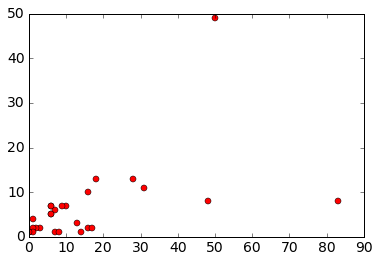

In [82]:
plt.plot(view_tweet_df["comments"], view_tweet_df["tweet_count"], 'ro')
plt.show()

In [83]:
np.corrcoef(view_tweet_df["views"], view_tweet_df["tweet_count"])

array([[ 1.       ,  0.3794663],
       [ 0.3794663,  1.       ]])

In [84]:
np.corrcoef(view_tweet_df["comments"], view_tweet_df["tweet_count"])

array([[ 1.        ,  0.52788993],
       [ 0.52788993,  1.        ]])

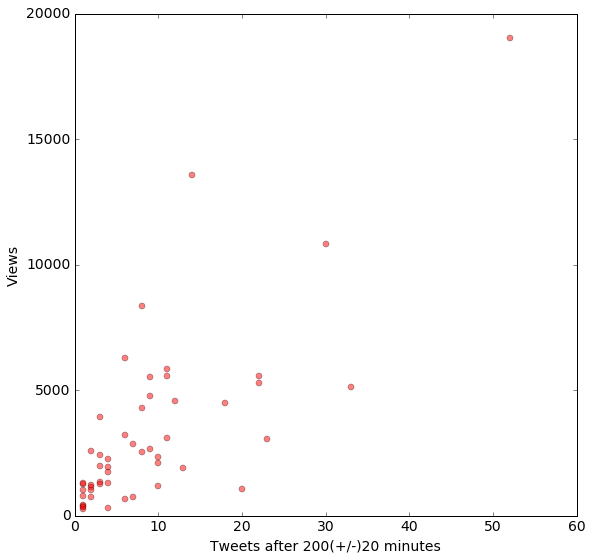

In [55]:
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9,9))
plt.plot(view_tweet_df["tweet_count"], view_tweet_df["views"], 'ro', label="predicted", alpha=0.5)
#plt.title(title)
plt.xlabel("Tweets after 200(+/-)20 minutes")
plt.ylabel("Views")
#plt.xscale('log')
#plt.yscale('log')
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()

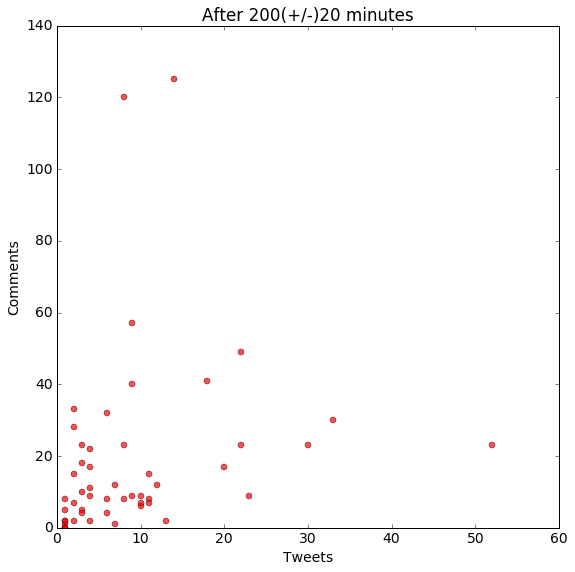

In [56]:
#plot(ltt, views, "Tweets after 180 minutes", "Views")
plt.figure(figsize=(9,9))
plt.plot(view_tweet_df["tweet_count"], view_tweet_df["comments"], 'ro', label="predicted", alpha=0.7)
plt.title("After 200(+/-)20 minutes")
plt.xlabel("Tweets")
plt.ylabel("Comments")
#max_y = max(max(y_true), max(y_predicted))+10
#plt.xlim(0, max_y)
#plt.ylim(0, max_y)
#plt.legend()
#plt.text(0.05*max_y, max_y-0.05*max_y, "mse="+text, fontsize=15)

#plt.plot([0, max_y], [0, max_y], color='black', alpha=0.5)
#plt.grid(b=True, which='both', color='0.65',linestyle='-')

plt.show()

In [77]:
# Чистка COMMENT_FILE
df = pd.read_csv(COMMENTS_COUNT_FILE, sep=",")
df = df[df["url"] == ""]
df.to_csv(COMMENTS_COUNT_FILE, sep=",", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)    